In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import binary_crossentropy

import warnings
warnings.filterwarnings(action = 'ignore')

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [2]:
df = pd.read_csv('./train.csv')

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
df.shape

(7613, 5)

Training dataset has 7,613 rows and 5 columns.

In [6]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [9]:
df.duplicated().sum()

0

There are no duplicate values in that dataset.

In [10]:
(df.isnull().sum() / df.shape[0]) * 100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [11]:
df[~(df['keyword'].isnull())]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [12]:
df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [13]:
df.groupby('keyword')['target'].value_counts()

keyword     target
ablaze      0         23
            1         13
accident    1         24
            0         11
aftershock  0         34
                      ..
wreck       0         30
            1          7
wreckage    1         39
wrecked     0         36
            1          3
Name: target, Length: 438, dtype: int64

In [14]:
df['tweet'] = np.where((df['keyword'].isnull()), df['text'], (df['keyword'] + ' ' + df['text']))

In [15]:
df[~df['keyword'].isnull()]['tweet']

31      ablaze @bbcmtd Wholesale Markets ablaze http:/...
32      ablaze We always try to bring the heavy. #meta...
33      ablaze #AFRICANBAZE: Breaking news:Nigeria fla...
34              ablaze Crying out for more! Set me ablaze
35      ablaze On plus side LOOK AT THE SKY LAST NIGHT...
                              ...                        
7578    wrecked @jt_ruff23 @cameronhacker and I wrecke...
7579    wrecked Three days off from work and they've p...
7580    wrecked #FX #forex #trading Cramer: Iger's 3 w...
7581    wrecked @engineshed Great atmosphere at the Br...
7582    wrecked Cramer: Iger's 3 words that wrecked Di...
Name: tweet, Length: 7552, dtype: object

In [16]:
to_drop = ['id', 'keyword', 'location', 'text']
df.drop(columns = to_drop, axis = 1, inplace=True)

In [17]:
df.isnull().sum()

target    0
tweet     0
dtype: int64

In [18]:
df.head()

,target,tweet
0,1,Our Deeds are the Reason of this #earthquake M...
1,1,Forest fire near La Ronge Sask. Canada
2,1,All residents asked to 'shelter in place' are ...
3,1,"13,000 people receive #wildfires evacuation or..."
4,1,Just got sent this photo from Ruby #Alaska as ...


In [19]:
X = df['tweet']
y = df['target']

In [20]:
X

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: tweet, Length: 7613, dtype: object

In [21]:
y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [22]:
X = X.values.flatten()
X

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [23]:
y.value_counts(normalize = True) * 100

0    57.034021
1    42.965979
Name: target, dtype: float64

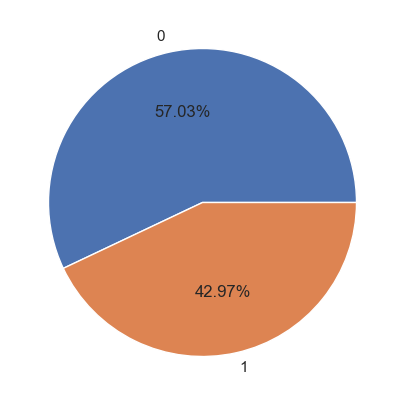

In [24]:
sns.set()
plt.figure(figsize = (5, 5))
plt.pie(x = ((y.value_counts(normalize = True) * 100).values), labels = ((y.value_counts(normalize = True) * 100).index), autopct= '%1.2f%%')
plt.show()

In [25]:
ps = PorterStemmer()
corpus = []

for i in range(0, len(X)):
    text = re.sub('a-zA-Z', ' ', X[i])
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    corpus.append(text)
    print(f'status : {i + 1}')

status : 1
status : 2
status : 3
status : 4
status : 5
status : 6
status : 7
status : 8
status : 9
status : 10
status : 11
status : 12
status : 13
status : 14
status : 15
status : 16
status : 17
status : 18
status : 19
status : 20
status : 21
status : 22
status : 23
status : 24
status : 25
status : 26
status : 27
status : 28
status : 29
status : 30
status : 31
status : 32
status : 33
status : 34
status : 35
status : 36
status : 37
status : 38
status : 39
status : 40
status : 41
status : 42
status : 43
status : 44
status : 45
status : 46
status : 47
status : 48
status : 49
status : 50
status : 51
status : 52
status : 53
status : 54
status : 55
status : 56
status : 57
status : 58
status : 59
status : 60
status : 61
status : 62
status : 63
status : 64
status : 65
status : 66
status : 67
status : 68
status : 69
status : 70
status : 71
status : 72
status : 73
status : 74
status : 75
status : 76
status : 77
status : 78
status : 79
status : 80
status : 81
status : 82
status : 83
status : 84
s

status : 716
status : 717
status : 718
status : 719
status : 720
status : 721
status : 722
status : 723
status : 724
status : 725
status : 726
status : 727
status : 728
status : 729
status : 730
status : 731
status : 732
status : 733
status : 734
status : 735
status : 736
status : 737
status : 738
status : 739
status : 740
status : 741
status : 742
status : 743
status : 744
status : 745
status : 746
status : 747
status : 748
status : 749
status : 750
status : 751
status : 752
status : 753
status : 754
status : 755
status : 756
status : 757
status : 758
status : 759
status : 760
status : 761
status : 762
status : 763
status : 764
status : 765
status : 766
status : 767
status : 768
status : 769
status : 770
status : 771
status : 772
status : 773
status : 774
status : 775
status : 776
status : 777
status : 778
status : 779
status : 780
status : 781
status : 782
status : 783
status : 784
status : 785
status : 786
status : 787
status : 788
status : 789
status : 790
status : 791
status : 792

status : 1359
status : 1360
status : 1361
status : 1362
status : 1363
status : 1364
status : 1365
status : 1366
status : 1367
status : 1368
status : 1369
status : 1370
status : 1371
status : 1372
status : 1373
status : 1374
status : 1375
status : 1376
status : 1377
status : 1378
status : 1379
status : 1380
status : 1381
status : 1382
status : 1383
status : 1384
status : 1385
status : 1386
status : 1387
status : 1388
status : 1389
status : 1390
status : 1391
status : 1392
status : 1393
status : 1394
status : 1395
status : 1396
status : 1397
status : 1398
status : 1399
status : 1400
status : 1401
status : 1402
status : 1403
status : 1404
status : 1405
status : 1406
status : 1407
status : 1408
status : 1409
status : 1410
status : 1411
status : 1412
status : 1413
status : 1414
status : 1415
status : 1416
status : 1417
status : 1418
status : 1419
status : 1420
status : 1421
status : 1422
status : 1423
status : 1424
status : 1425
status : 1426
status : 1427
status : 1428
status : 1429
status

status : 1949
status : 1950
status : 1951
status : 1952
status : 1953
status : 1954
status : 1955
status : 1956
status : 1957
status : 1958
status : 1959
status : 1960
status : 1961
status : 1962
status : 1963
status : 1964
status : 1965
status : 1966
status : 1967
status : 1968
status : 1969
status : 1970
status : 1971
status : 1972
status : 1973
status : 1974
status : 1975
status : 1976
status : 1977
status : 1978
status : 1979
status : 1980
status : 1981
status : 1982
status : 1983
status : 1984
status : 1985
status : 1986
status : 1987
status : 1988
status : 1989
status : 1990
status : 1991
status : 1992
status : 1993
status : 1994
status : 1995
status : 1996
status : 1997
status : 1998
status : 1999
status : 2000
status : 2001
status : 2002
status : 2003
status : 2004
status : 2005
status : 2006
status : 2007
status : 2008
status : 2009
status : 2010
status : 2011
status : 2012
status : 2013
status : 2014
status : 2015
status : 2016
status : 2017
status : 2018
status : 2019
status

status : 2575
status : 2576
status : 2577
status : 2578
status : 2579
status : 2580
status : 2581
status : 2582
status : 2583
status : 2584
status : 2585
status : 2586
status : 2587
status : 2588
status : 2589
status : 2590
status : 2591
status : 2592
status : 2593
status : 2594
status : 2595
status : 2596
status : 2597
status : 2598
status : 2599
status : 2600
status : 2601
status : 2602
status : 2603
status : 2604
status : 2605
status : 2606
status : 2607
status : 2608
status : 2609
status : 2610
status : 2611
status : 2612
status : 2613
status : 2614
status : 2615
status : 2616
status : 2617
status : 2618
status : 2619
status : 2620
status : 2621
status : 2622
status : 2623
status : 2624
status : 2625
status : 2626
status : 2627
status : 2628
status : 2629
status : 2630
status : 2631
status : 2632
status : 2633
status : 2634
status : 2635
status : 2636
status : 2637
status : 2638
status : 2639
status : 2640
status : 2641
status : 2642
status : 2643
status : 2644
status : 2645
status

status : 3163
status : 3164
status : 3165
status : 3166
status : 3167
status : 3168
status : 3169
status : 3170
status : 3171
status : 3172
status : 3173
status : 3174
status : 3175
status : 3176
status : 3177
status : 3178
status : 3179
status : 3180
status : 3181
status : 3182
status : 3183
status : 3184
status : 3185
status : 3186
status : 3187
status : 3188
status : 3189
status : 3190
status : 3191
status : 3192
status : 3193
status : 3194
status : 3195
status : 3196
status : 3197
status : 3198
status : 3199
status : 3200
status : 3201
status : 3202
status : 3203
status : 3204
status : 3205
status : 3206
status : 3207
status : 3208
status : 3209
status : 3210
status : 3211
status : 3212
status : 3213
status : 3214
status : 3215
status : 3216
status : 3217
status : 3218
status : 3219
status : 3220
status : 3221
status : 3222
status : 3223
status : 3224
status : 3225
status : 3226
status : 3227
status : 3228
status : 3229
status : 3230
status : 3231
status : 3232
status : 3233
status

status : 3793
status : 3794
status : 3795
status : 3796
status : 3797
status : 3798
status : 3799
status : 3800
status : 3801
status : 3802
status : 3803
status : 3804
status : 3805
status : 3806
status : 3807
status : 3808
status : 3809
status : 3810
status : 3811
status : 3812
status : 3813
status : 3814
status : 3815
status : 3816
status : 3817
status : 3818
status : 3819
status : 3820
status : 3821
status : 3822
status : 3823
status : 3824
status : 3825
status : 3826
status : 3827
status : 3828
status : 3829
status : 3830
status : 3831
status : 3832
status : 3833
status : 3834
status : 3835
status : 3836
status : 3837
status : 3838
status : 3839
status : 3840
status : 3841
status : 3842
status : 3843
status : 3844
status : 3845
status : 3846
status : 3847
status : 3848
status : 3849
status : 3850
status : 3851
status : 3852
status : 3853
status : 3854
status : 3855
status : 3856
status : 3857
status : 3858
status : 3859
status : 3860
status : 3861
status : 3862
status : 3863
status

status : 4445
status : 4446
status : 4447
status : 4448
status : 4449
status : 4450
status : 4451
status : 4452
status : 4453
status : 4454
status : 4455
status : 4456
status : 4457
status : 4458
status : 4459
status : 4460
status : 4461
status : 4462
status : 4463
status : 4464
status : 4465
status : 4466
status : 4467
status : 4468
status : 4469
status : 4470
status : 4471
status : 4472
status : 4473
status : 4474
status : 4475
status : 4476
status : 4477
status : 4478
status : 4479
status : 4480
status : 4481
status : 4482
status : 4483
status : 4484
status : 4485
status : 4486
status : 4487
status : 4488
status : 4489
status : 4490
status : 4491
status : 4492
status : 4493
status : 4494
status : 4495
status : 4496
status : 4497
status : 4498
status : 4499
status : 4500
status : 4501
status : 4502
status : 4503
status : 4504
status : 4505
status : 4506
status : 4507
status : 4508
status : 4509
status : 4510
status : 4511
status : 4512
status : 4513
status : 4514
status : 4515
status

status : 5067
status : 5068
status : 5069
status : 5070
status : 5071
status : 5072
status : 5073
status : 5074
status : 5075
status : 5076
status : 5077
status : 5078
status : 5079
status : 5080
status : 5081
status : 5082
status : 5083
status : 5084
status : 5085
status : 5086
status : 5087
status : 5088
status : 5089
status : 5090
status : 5091
status : 5092
status : 5093
status : 5094
status : 5095
status : 5096
status : 5097
status : 5098
status : 5099
status : 5100
status : 5101
status : 5102
status : 5103
status : 5104
status : 5105
status : 5106
status : 5107
status : 5108
status : 5109
status : 5110
status : 5111
status : 5112
status : 5113
status : 5114
status : 5115
status : 5116
status : 5117
status : 5118
status : 5119
status : 5120
status : 5121
status : 5122
status : 5123
status : 5124
status : 5125
status : 5126
status : 5127
status : 5128
status : 5129
status : 5130
status : 5131
status : 5132
status : 5133
status : 5134
status : 5135
status : 5136
status : 5137
status

status : 5708
status : 5709
status : 5710
status : 5711
status : 5712
status : 5713
status : 5714
status : 5715
status : 5716
status : 5717
status : 5718
status : 5719
status : 5720
status : 5721
status : 5722
status : 5723
status : 5724
status : 5725
status : 5726
status : 5727
status : 5728
status : 5729
status : 5730
status : 5731
status : 5732
status : 5733
status : 5734
status : 5735
status : 5736
status : 5737
status : 5738
status : 5739
status : 5740
status : 5741
status : 5742
status : 5743
status : 5744
status : 5745
status : 5746
status : 5747
status : 5748
status : 5749
status : 5750
status : 5751
status : 5752
status : 5753
status : 5754
status : 5755
status : 5756
status : 5757
status : 5758
status : 5759
status : 5760
status : 5761
status : 5762
status : 5763
status : 5764
status : 5765
status : 5766
status : 5767
status : 5768
status : 5769
status : 5770
status : 5771
status : 5772
status : 5773
status : 5774
status : 5775
status : 5776
status : 5777
status : 5778
status

status : 6305
status : 6306
status : 6307
status : 6308
status : 6309
status : 6310
status : 6311
status : 6312
status : 6313
status : 6314
status : 6315
status : 6316
status : 6317
status : 6318
status : 6319
status : 6320
status : 6321
status : 6322
status : 6323
status : 6324
status : 6325
status : 6326
status : 6327
status : 6328
status : 6329
status : 6330
status : 6331
status : 6332
status : 6333
status : 6334
status : 6335
status : 6336
status : 6337
status : 6338
status : 6339
status : 6340
status : 6341
status : 6342
status : 6343
status : 6344
status : 6345
status : 6346
status : 6347
status : 6348
status : 6349
status : 6350
status : 6351
status : 6352
status : 6353
status : 6354
status : 6355
status : 6356
status : 6357
status : 6358
status : 6359
status : 6360
status : 6361
status : 6362
status : 6363
status : 6364
status : 6365
status : 6366
status : 6367
status : 6368
status : 6369
status : 6370
status : 6371
status : 6372
status : 6373
status : 6374
status : 6375
status

status : 6899
status : 6900
status : 6901
status : 6902
status : 6903
status : 6904
status : 6905
status : 6906
status : 6907
status : 6908
status : 6909
status : 6910
status : 6911
status : 6912
status : 6913
status : 6914
status : 6915
status : 6916
status : 6917
status : 6918
status : 6919
status : 6920
status : 6921
status : 6922
status : 6923
status : 6924
status : 6925
status : 6926
status : 6927
status : 6928
status : 6929
status : 6930
status : 6931
status : 6932
status : 6933
status : 6934
status : 6935
status : 6936
status : 6937
status : 6938
status : 6939
status : 6940
status : 6941
status : 6942
status : 6943
status : 6944
status : 6945
status : 6946
status : 6947
status : 6948
status : 6949
status : 6950
status : 6951
status : 6952
status : 6953
status : 6954
status : 6955
status : 6956
status : 6957
status : 6958
status : 6959
status : 6960
status : 6961
status : 6962
status : 6963
status : 6964
status : 6965
status : 6966
status : 6967
status : 6968
status : 6969
status

status : 7548
status : 7549
status : 7550
status : 7551
status : 7552
status : 7553
status : 7554
status : 7555
status : 7556
status : 7557
status : 7558
status : 7559
status : 7560
status : 7561
status : 7562
status : 7563
status : 7564
status : 7565
status : 7566
status : 7567
status : 7568
status : 7569
status : 7570
status : 7571
status : 7572
status : 7573
status : 7574
status : 7575
status : 7576
status : 7577
status : 7578
status : 7579
status : 7580
status : 7581
status : 7582
status : 7583
status : 7584
status : 7585
status : 7586
status : 7587
status : 7588
status : 7589
status : 7590
status : 7591
status : 7592
status : 7593
status : 7594
status : 7595
status : 7596
status : 7597
status : 7598
status : 7599
status : 7600
status : 7601
status : 7602
status : 7603
status : 7604
status : 7605
status : 7606
status : 7607
status : 7608
status : 7609
status : 7610
status : 7611
status : 7612
status : 7613


In [26]:
corpus

['deed reason #earthquak may allah forgiv us',
 'forest fire near la rong sask. canada',
 "resid ask 'shelter place' notifi officers. evacu shelter place order expect",
 '13,000 peopl receiv #wildfir evacu order california',
 'got sent photo rubi #alaska smoke #wildfir pour school',
 '#rockyfir updat => california hwy. 20 close direct due lake counti fire - #cafir #wildfir',
 '#flood #disast heavi rain caus flash flood street manitou, colorado spring area',
 "i'm top hill see fire woods...",
 "there' emerg evacu happen build across street",
 "i'm afraid tornado come area...",
 'three peopl die heat wave far',
 'haha south tampa get flood hah- wait second live south tampa gonna gonna fvck #flood',
 "#rain #flood #florida #tampabay #tampa 18 19 days. i'v lost count",
 '#flood bago myanmar #we arriv bago',
 'damag school bu 80 multi car crash #break',
 "what' man?",
 'love fruit',
 'summer love',
 'car fast',
 'goooooooaaaaaal!!!!!!',
 'ridiculous....',
 'london cool ;)',
 'love ski',
 'w

In [27]:
print(f"Before preprocessing : {X[0]}")
print(f"After preprocessing : {corpus[0]}")

Before preprocessing : Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
After preprocessing : deed reason #earthquak may allah forgiv us


In [28]:
voc_size = 5000
one_hot_re = [one_hot(text, n = voc_size) for text in corpus]
one_hot_re

[[3101, 3486, 766, 1747, 2322, 983, 34],
 [2863, 3359, 2345, 1967, 2434, 1012, 4887],
 [1830, 128, 4567, 4158, 3662, 4449, 56, 2075, 2530, 3061, 578],
 [4034, 3211, 1005, 3322, 571, 56, 3061, 1830],
 [817, 4462, 1302, 3916, 1947, 4963, 571, 2638, 4382],
 [3359, 4743, 1830, 131, 3113, 4623, 4634, 4408, 4577, 509, 3359, 3359, 571],
 [2358, 4405, 1542, 4575, 2004, 2245, 2358, 1062, 1191, 3216, 340, 2863],
 [1725, 3866, 1077, 1833, 3359, 4642],
 [2882, 4180, 56, 1261, 3335, 1192, 1062],
 [1725, 2821, 1648, 744, 2863],
 [4366, 1005, 812, 4719, 361, 2063],
 [2262,
  4660,
  3329,
  1524,
  2358,
  4837,
  3250,
  731,
  4154,
  4660,
  3329,
  1998,
  1998,
  3537,
  2358],
 [4575, 2358, 2044, 3686, 3329, 1514, 1305, 315, 4, 3833, 2952],
 [2358, 1727, 2522, 3090, 2083, 1727],
 [4510, 4382, 3468, 161, 4334, 4068, 4043, 2916],
 [4520, 359],
 [3707, 1620],
 [2020, 3707],
 [4068, 3400],
 [18],
 [3247],
 [2429, 320],
 [3707, 2589],
 [362, 2018],
 [180],
 [3388, 861, 2917, 1274, 535],
 [949, 1905,

In [29]:
max_len = 0
lent = []

for i in range(0, len(one_hot_re)):
    lent.append(len(one_hot_re[i]))
    
max_len = max(lent)
print(f'max lenth : {max_len}')

max lenth : 29


In [30]:
text_with_pad = pad_sequences(sequences=one_hot_re, padding= 'pre', maxlen = max_len)
text_with_pad

array([[   0,    0,    0, ..., 2322,  983,   34],
       [   0,    0,    0, ..., 2434, 1012, 4887],
       [   0,    0,    0, ..., 2530, 3061,  578],
       ...,
       [   0,    0,    0, ..., 3006, 1951,  145],
       [   0,    0,    0, ..., 2162, 2221, 1106],
       [   0,    0,    0, ..., 3006, 1951, 1993]])

In [31]:
out_cat = len(y.unique())
out_cat

2

In [32]:
X = np.array(text_with_pad)
y = np.array(y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, train_size= 0.8, shuffle= True)

In [34]:
print(f"X_train has : {X_train.shape}")
print(f"y_train has : {y_train.shape}")
print(f"X_test has : {X_test.shape}")
print(f"y_train has : {y_test.shape}")

X_train has : (6090, 29)
y_train has : (6090,)
X_test has : (1523, 29)
y_train has : (1523,)


In [40]:
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 2)

In [41]:
model1 = Sequential([
    Embedding(input_dim=voc_size, output_dim=40, input_length= max_len),
    LSTM(units= 128),
    Dense(units= 1, activation= 'relu')
])

In [42]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 29, 40)            200000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               86528     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 286657 (1.09 MB)
Trainable params: 286657 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
model1.compile(optimizer= Adam(), 
             loss = binary_crossentropy,
             metrics= ['acc'])

In [44]:
model1_hist = model1.fit(x = X_train, 
                      y = y_train,
                      validation_data= (X_test, y_test),
                      epochs= 5,
                      batch_size = 50, callbacks= [early_stopping])

Epoch 1/5
122/122 [==============================] - 5s 27ms/step - loss: 0.6752 - acc: 0.6512 - val_loss: 0.7021 - val_acc: 0.7236
Epoch 2/5
122/122 [==============================] - 3s 21ms/step - loss: 0.5173 - acc: 0.8026 - val_loss: 0.6181 - val_acc: 0.7341
Epoch 3/5
122/122 [==============================] - 3s 22ms/step - loss: 0.4340 - acc: 0.8251 - val_loss: 0.8713 - val_acc: 0.7617
Epoch 4/5
122/122 [==============================] - 3s 21ms/step - loss: 0.3490 - acc: 0.8677 - val_loss: 1.3890 - val_acc: 0.7446


In [95]:
def plot(hist):
    hist_df = pd.DataFrame(data = hist.history)
    
    hist_df[['loss', 'val_loss']].plot()
    plt.xlabel('Number of epochs')
    plt.ylabel('loss')
    hist_df[['acc', 'val_acc']].plot()
    plt.xlabel('Num of epochs')
    plt.ylabel('Accuracy')
    plt.show()

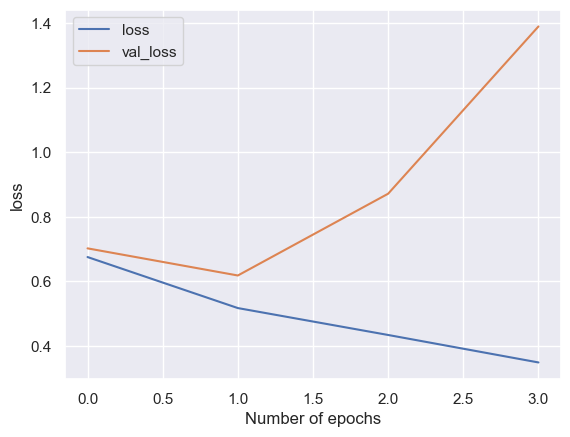

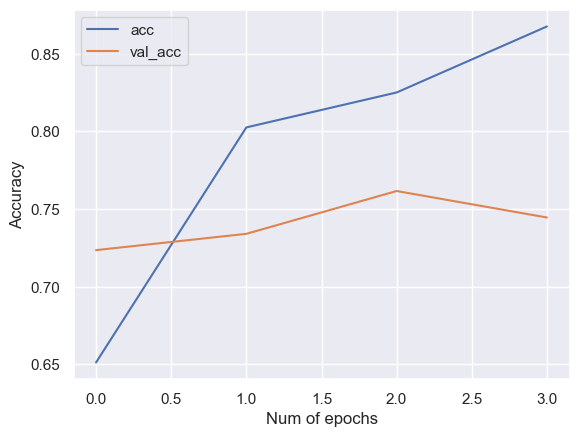

In [96]:
plot(model1_hist)

In [97]:
model2 = Sequential([
    Embedding(input_dim=voc_size, output_dim=40, input_length= max_len),
    Bidirectional(LSTM(units= 128)),
    Dense(units= 1, activation= 'relu')
])

In [98]:
model2.compile(optimizer= Adam(), 
             loss = binary_crossentropy,
             metrics= ['acc'])

In [99]:
model2_hist = model1.fit(x = X_train, 
                      y = y_train,
                      validation_data= (X_test, y_test),
                      epochs= 5,
                      batch_size = 50, callbacks= [early_stopping])

Epoch 1/5
122/122 [==============================] - 3s 22ms/step - loss: 0.2724 - acc: 0.9227 - val_loss: 1.6649 - val_acc: 0.7393
Epoch 2/5
122/122 [==============================] - 3s 22ms/step - loss: 0.1986 - acc: 0.9550 - val_loss: 2.1722 - val_acc: 0.7308
Epoch 3/5
122/122 [==============================] - 3s 22ms/step - loss: 0.1685 - acc: 0.9718 - val_loss: 2.3102 - val_acc: 0.7347


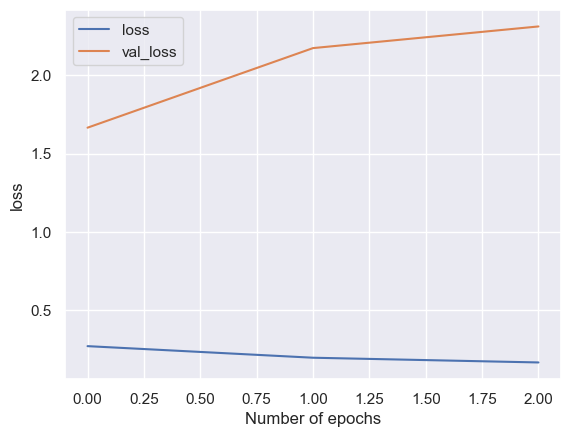

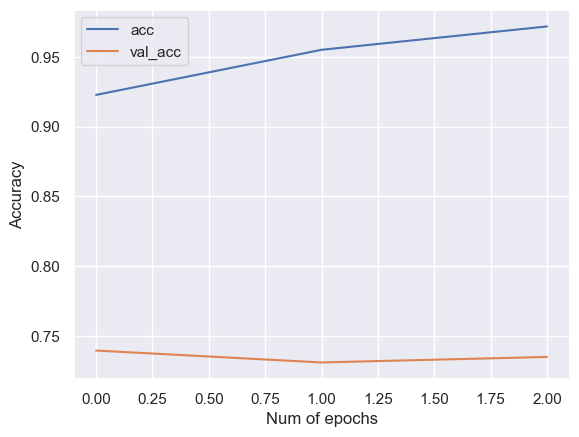

In [100]:
plot(model2_hist)